In [1]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import PreProcessor as pp

In [2]:
dataset = pp.load_dataset("adl-piano-midi")
ClassicSongs = pp.files_to_songs(dataset["Classical"])

channel_to_ind, ind_to_channel, note_to_ind, ind_to_note = pp.dicts_from_songs(ClassicSongs)
velocity_range, time_range = pp.ranges_from_songs(ClassicSongs)

n_Channels = len(channel_to_ind)
n_Notes = len(note_to_ind)

print("\nNumber of channels  :",n_Channels,"\nNumber of notes     :",n_Notes,"\nVelocity range      :",velocity_range[0],velocity_range[1],"\nTime range          :",time_range[0],time_range[1])

Couldn't load : adl-piano-midi\Classical\Classical\Alexander Borodin\Nocturne.mid
Couldn't load : adl-piano-midi\Classical\Classical\Antonio Salieri\Invention.mid
Couldn't load : adl-piano-midi\Classical\Classical\Bela Bartok\Andante.mid
Couldn't load : adl-piano-midi\Classical\Classical\Bela Bartok\Romanian Folk Dance.mid
Couldn't load : adl-piano-midi\Classical\Classical\Claude Debussy\Clair De Lune.mid
Couldn't load : adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in C-Moll.mid
Couldn't load : adl-piano-midi\Classical\Classical\Franz Schubert\Impromptu in Ges-dur.mid
Couldn't load : adl-piano-midi\Classical\Classical\Franz Schubert\Trois Marches militaires 3.mid
Couldn't load : adl-piano-midi\Classical\Classical\Frederic Chopin\Prelude Op 28 No7.mid
Couldn't load : adl-piano-midi\Classical\Classical\Giacomo Puccini\O Mio Babibino Caro.mid
Couldn't load : adl-piano-midi\Classical\Classical\Jean-Baptiste Lully\Minuet.mid
Couldn't load : adl-piano-midi\Classical\Classical\

In [10]:
AllChannels = np.array([],dtype=int)
AllNotes = np.array([],dtype=int)
AllVelocities = np.array([],dtype=int)
AllTimes = np.array([])
for song in ClassicSongs.values():
    AllChannels = np.append(AllChannels,song[:,0].astype(int))
    AllNotes = np.append(AllNotes,song[:,1].astype(int))
    AllVelocities = np.append(AllVelocities,song[:,2].astype(int))
    AllTimes = np.append(AllTimes,song[:,3])

OneHotChannels = pp.one_hot_encode(channel_to_ind,AllChannels)
OneHotNotes = pp.one_hot_encode(note_to_ind,AllNotes)
AllVelocities = AllVelocities.reshape((-1,1))
AllTimes = AllTimes.reshape((-1,1))

In [13]:
seq_length = 30
n_batch = 200

X_channels, y_channels = pp.label_sequences(OneHotChannels,seq_length,n_batch)
X_notes, y_notes = pp.label_sequences(OneHotNotes,seq_length,n_batch)
X_velocities, y_velocities = pp.label_sequences(AllVelocities,seq_length,n_batch)
X_times, y_times = pp.label_sequences(AllTimes,seq_length,n_batch)
print(X_channels.shape)
print(X_notes.shape)
print(X_velocities.shape)
print(X_times.shape)

#X_train = np.concatenate([X_notes, X_velocities], axis=2) #np.concatenate([X_channels, X_notes, X_velocities, X_times], axis=2)
#y_train = np.concatenate([y_notes, y_velocities], axis=2) #np.concatenate([y_channels, y_notes, y_velocities, y_times], axis=2)
#print(X_train.shape)
#print(y_train.shape)

(73600, 30, 12)
(73600, 30, 105)
(73600, 30, 1)
(73600, 30, 1)


In [3]:
seq_length = 30
n_batch = 200

X_channels = np.array([]).reshape(0,seq_length,n_Channels)
X_Notes = np.array([]).reshape(0,seq_length,n_Notes)
X_Velocities = np.array([]).reshape(0,seq_length,1)
X_Times = np.array([]).reshape(0,seq_length,1)
y_channels = np.array([]).reshape(0,seq_length,n_Channels)
y_Notes = np.array([]).reshape(0,seq_length,n_Notes)
y_Velocities = np.array([]).reshape(0,seq_length,1)
y_Times = np.array([]).reshape(0,seq_length,1)
for song in classicSongs.values():
    song_x_channels, song_y_channels = pp.label_sequences(pp.one_hot_encode(channel_to_ind,song[:,0]),seq_length)
    song_x_notes, song_y_notes = pp.label_sequences(pp.one_hot_encode(note_to_ind,song[:,1]),seq_length)
    song_x_velocities, song_y_velocities = pp.label_sequences(song[:,2:3],seq_length)
    song_x_ticks, song_y_ticks = pp.label_sequences(song[:,3:],seq_length)
    
    X_channels = np.append(X_channels,song_x_channels,axis=0)
    X_Notes = np.append(X_Notes,song_x_notes,axis=0)
    X_Velocities = np.append(X_Velocities,song_x_velocities,axis=0)
    X_Times = np.append(X_Times,song_x_ticks,axis=0)
    y_channels = np.append(y_channels,song_y_channels,axis=0)
    y_Notes = np.append(y_Notes,song_y_notes,axis=0)
    y_Velocities = np.append(y_Velocities,song_y_velocities,axis=0)
    y_Times = np.append(y_Times,song_y_ticks,axis=0)

n_samples = (X_channels.shape[0]//n_batch)*n_batch

X_channels = X_channels[:n_samples,:,:]
X_Notes = X_Notes[:n_samples,:,:]
X_Velocities = X_Velocities[:n_samples,:,:]
X_Times = X_Times[:n_samples,:,:]
y_channels = y_channels[:n_samples,:,:]
y_Notes = y_Notes[:n_samples,:,:]
y_Velocities = y_Velocities[:n_samples,:,:]
y_Times = y_Times[:n_samples,:,:]

print(X_channels.shape)
print(X_Notes.shape)
print(X_Velocities.shape)
print(X_Times.shape)

(70800, 30, 12)
(70800, 30, 105)
(70800, 30, 1)
(70800, 30, 1)


In [4]:
from keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Lambda, Softmax, Activation, concatenate
from keras import optimizers
import tensorflow as tf

In [5]:
def rounded_accuracy(y_true, y_pred):
    y_pred_rounded = tf.round(y_pred)
    correct_predictions = tf.equal(tf.cast(y_pred_rounded, tf.int32), tf.cast(y_true, tf.int32))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

def tol_accuracy(y_true, y_pred):
    threshold = 0.25
    difference = tf.abs(tf.subtract(y_true, y_pred)) - threshold
    correct_predictions = tf.where(difference <= 0, True, False)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [6]:
dim = 300

lossRNN = []
channels_accuracyRNN = []
notes_accuracyRNN = []
velocities_accuracyRNN = []
times_accuracyRNN = []

# Define input layer
input_channels = Input(shape=(None, n_Channels))
input_notes = Input(shape=(None, n_Notes))
input_velocities = Input(shape=(None, 1))
input_times = Input(shape=(None, 1))

# Define SimpleRNN layer
rnn_output = SimpleRNN(units=dim, return_sequences=True)(concatenate([input_channels, input_notes, input_velocities, input_times]))

# Define Dense layer for each branch
channels_output = Dense(units=n_Channels)(rnn_output)
notes_output = Dense(units=n_Notes)(rnn_output)
velocities_output = Dense(units=1)(rnn_output)
times_output = Dense(units=1)(rnn_output)

# Use Lambda layer to split the output of SimpleRNN into two branches
final_channels = Softmax(name="Channels")(channels_output)
final_notes = Softmax(name="Notes")(notes_output)
final_velocities = Lambda(lambda x: (tf.sigmoid(x) * (velocity_range[1] - velocity_range[0]) + velocity_range[0]), name="Velocities")(velocities_output)
final_times = Lambda(lambda x: (tf.sigmoid(x) * (time_range[1] - time_range[0]) + time_range[0]), name="Times")(times_output)

# Define the model with inputs and outputs
RNN_model = Model(inputs=[input_channels, input_notes, input_velocities, input_times], outputs=[final_channels, final_notes, final_velocities, final_times], name="RNN_model")

RNN_model.summary()

Model: "RNN_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 12)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 105)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                          

In [7]:
n_epochs = 2

lossesRNN = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'mean_squared_error',
    'Times': 'mean_squared_error'
}


loss_weightsRNN = {
    'Channels': 0.5,
    'Notes': 5.0,
    'Velocities': 0.02,
    'Times': 2e-7
}

metricsRNN = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': rounded_accuracy,
    'Times': tol_accuracy
}

RNN_model.compile(optimizer='adam', loss=lossesRNN, loss_weights=loss_weightsRNN, metrics=metricsRNN)
history = RNN_model.fit([X_channels, X_notes, X_velocities, X_times], [y_channels, y_notes, y_velocities, y_times], epochs=n_epochs, batch_size=n_batch)

lossRNN += history.history['loss']
channels_accuracyRNN += history.history['Channels_accuracy']
notes_accuracyRNN += history.history['Notes_accuracy']
velocities_accuracyRNN += history.history['Velocities_rounded_accuracy']
times_accuracyRNN += history.history['Times_tol_accuracy']

NameError: name 'X_channels' is not defined

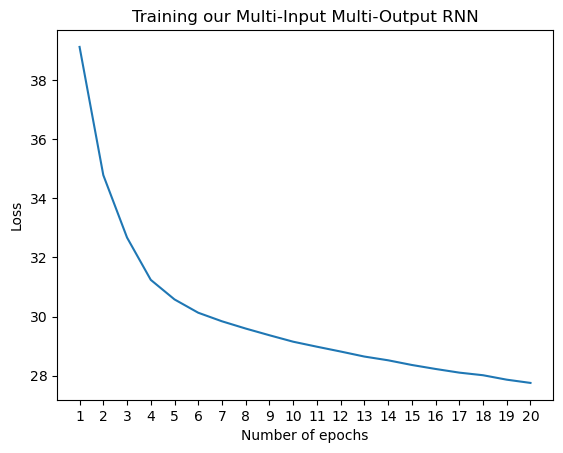

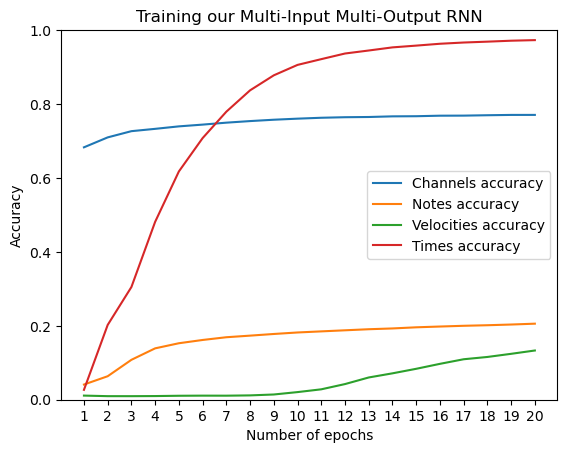

In [27]:
x = range(1,len(lossRNN)+1)
plt.figure()
plt.plot(x, lossRNN)
plt.title("Training our Multi-Input Multi-Output RNN")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.xticks(x)
plt.show()
plt.figure()
plt.plot(x, channels_accuracyRNN, label="Channels accuracy")
plt.plot(x, notes_accuracyRNN, label="Notes accuracy")
plt.plot(x, velocities_accuracyRNN, label="Velocities accuracy")
plt.plot(x, times_accuracyRNN, label="Times accuracy")
plt.legend()
plt.ylim([0,1])
plt.title("Training our Multi-Input Multi-Output RNN")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.xticks(x)
plt.show()

In [22]:
dim = 140

lossLSTM = []
channels_accuracyLSTM = []
notes_accuracyLSTM = []
velocities_accuracyLSTM = []
times_accuracyLSTM = []

# Define input layers for notes and velocities
#input_channels = Input(shape=(None, n_Channels))
#input_notes = Input(shape=(None, n_Notes))
#input_velocities = Input(shape=(None, 1))
#input_times = Input(shape=(None, 1))

# Define LSTM layer
lstm_output = LSTM(units=dim, return_sequences=True)(concatenate([input_channels, input_notes, input_velocities, input_times]))

# Define Dense layer for each branch
channels_output_lstm = Dense(units=n_Channels)(lstm_output)
notes_output_lstm = Dense(units=n_Notes)(lstm_output)
velocities_output_lstm = Dense(units=1)(lstm_output)
times_output_lstm = Dense(units=1)(lstm_output)

# Use Lambda layer to split the output of SimpleLSTM into two branches
lstm_final_channels = Softmax(name="Channels")(channels_output_lstm)
lstm_final_notes = Softmax(name="Notes")(notes_output_lstm)
lstm_final_velocities = Lambda(lambda x: (tf.sigmoid(x) * (velocity_range[1] - velocity_range[0]) + velocity_range[0]), name="Velocities")(velocities_output_lstm)
lstm_final_times = Lambda(lambda x: (tf.sigmoid(x) * (time_range[1] - time_range[0]) + time_range[0]), name="Times")(times_output_lstm)

# Define the model with inputs and outputs
LSTM_model = Model(inputs=[input_channels, input_notes, input_velocities, input_times], outputs=[lstm_final_channels, lstm_final_notes, lstm_final_velocities, lstm_final_times], name="LSTM_model")

LSTM_model.summary()

Model: "LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 12)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None, 105)]  0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, None, 1)]    0           []                               
                                                                                         

In [12]:
n_epochs = 20

lossesLSTM = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'mean_squared_error',
    'Times': 'mean_squared_error'
}


loss_weightsLSTM = {
    'Channels': 0.5,
    'Notes': 5.0,
    'Velocities': 0.02,
    'Times': 2e-7
}

metricsLSTM = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': rounded_accuracy,
    'Times': tol_accuracy
}

LSTM_model.compile(optimizer='adam', loss=lossesLSTM, loss_weights=loss_weightsLSTM, metrics=metricsLSTM)
history = LSTM_model.fit([X_channels, X_notes, X_velocities, X_times], [y_channels, y_notes, y_velocities, y_times], epochs=n_epochs, batch_size=n_batch)

lossLSTM += history.history['loss']
channels_accuracyLSTM += history.history['Channels_accuracy']
notes_accuracyLSTM += history.history['Notes_accuracy']
velocities_accuracyLSTM += history.history['Velocities_rounded_accuracy']
times_accuracyLSTM += history.history['Times_tol_accuracy']

Epoch 1/20
358/358 [==============================] - 39s 99ms/step - loss: 36.8778 - Channels_loss: 0.8477 - Notes_loss: 3.9568 - Velocities_loss: 833.4832 - Times_loss: 1067.1808 - Channels_accuracy: 0.6735 - Notes_accuracy: 0.0429 - Velocities_rounded_accuracy: 0.0104 - Times_rounded_accuracy: 0.0020
Epoch 2/20
358/358 [==============================] - 36s 99ms/step - loss: 32.4604 - Channels_loss: 0.6292 - Notes_loss: 3.5530 - Velocities_loss: 719.0268 - Times_loss: 56.9609 - Channels_accuracy: 0.7127 - Notes_accuracy: 0.0927 - Velocities_rounded_accuracy: 0.0109 - Times_rounded_accuracy: 0.0595
Epoch 3/20
358/358 [==============================] - 37s 105ms/step - loss: 30.6647 - Channels_loss: 0.5577 - Notes_loss: 3.2835 - Velocities_loss: 698.4118 - Times_loss: 24.1194 - Channels_accuracy: 0.7331 - Notes_accuracy: 0.1226 - Velocities_rounded_accuracy: 0.0116 - Times_rounded_accuracy: 0.2745
Epoch 4/20
358/358 [==============================] - 35s 98ms/step - loss: 29.8130 - Ch

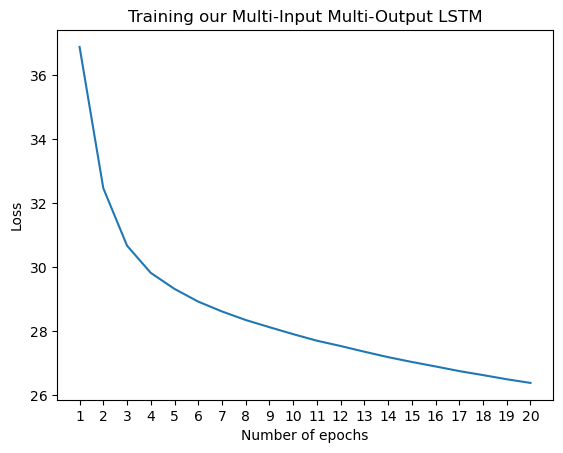

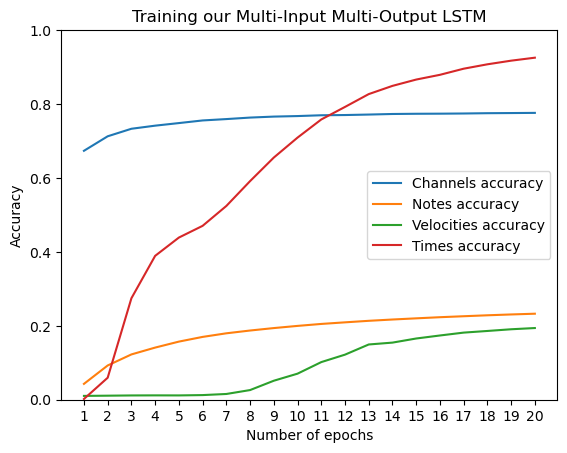

In [13]:
x = range(1,len(lossLSTM)+1)
plt.figure()
plt.plot(x, lossLSTM)
plt.title("Training our Multi-Input Multi-Output LSTM")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.xticks(x)
plt.show()
plt.figure()
plt.plot(x, channels_accuracyLSTM, label="Channels accuracy")
plt.plot(x, notes_accuracyLSTM, label="Notes accuracy")
plt.plot(x, velocities_accuracyLSTM, label="Velocities accuracy")
plt.plot(x, times_accuracyLSTM, label="Times accuracy")
plt.legend()
plt.ylim([0,1])
plt.title("Training our Multi-Input Multi-Output LSTM")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.xticks(x)
plt.show()

In [23]:
def sample_probas(vec, mode, T):
    output = []
    if mode == "Max":
        channels = np.zeros_like(vec[0])
        i = np.argmax(vec[0][0,0,:])
        channels[0,0,i] = 1
        output += [channels]
        
        notes = np.zeros_like(vec[1])
        i = np.argmax(vec[1][0,0,:])
        notes[0,0,i] = 1
        output += [notes]
    
    if mode == "Original":
        p = vec[0][0,0,:]
        channels = np.zeros_like(vec[0])
        i = np.random.choice(range(len(p)),p=p)
        channels[0,0,i] = 1
        output += [channels]
        
        p = vec[1][0,0,:]
        notes = np.zeros_like(vec[1])
        i = np.random.choice(range(len(p)),p=p)
        notes[0,0,i] = 1
        output += [notes]
        
    if mode == "NucleusSampling":
        p = vec[0][0,0,:]
        sorted_p = np.sort(p)[::-1]
        cum_p = np.cumsum(sorted_p)
        k = np.sum(cum_p < T) + 1
        indices = np.argsort(p)[:-k]
        p[indices] = 0
        i = np.random.choice(range(len(p)),p=p/cum_p[k-1])
        channels = np.zeros_like(vec[0])
        channels[0,0,i] = 1
        output += [channels]
        
        p = vec[1][0,0,:]
        sorted_p = np.sort(p)[::-1]
        cum_p = np.cumsum(sorted_p)
        k = np.sum(cum_p < T) + 1
        indices = np.argsort(p)[:-k]
        p[indices] = 0
        i = np.random.choice(range(len(p)),p=p/cum_p[k-1])
        notes = np.zeros_like(vec[1])
        notes[0,0,i] = 1
        output += [notes]
        
    output += [np.rint(vec[2]).astype(int)]
    output += [vec[3]]
    return output

def generate(model,input_vec,output_length,mode="Max",T=1,one_hot=False,reset=False):
    stateful = model.stateful
    model.stateful = True
    if reset : model.reset_states()
    temp_vec = model.predict(input_vec)
    for i in range(4):
        temp_vec[i] = temp_vec[i][:,-1:,:]
    temp_vec = sample_probas(temp_vec,mode,T)
    if one_hot :
        output_vec = temp_vec
    else :
        output_vec = [[ind_to_channel[np.argmax(temp_vec[0][0,0,:])],ind_to_note[np.argmax(temp_vec[1][0,0,:])],temp_vec[2][0,0,0],temp_vec[3][0,0,0]]]
    for i in range(output_length-1):
        temp_vec = model.predict(temp_vec)
        temp_vec = sample_probas(temp_vec,mode,T)
        if one_hot :
            for j in range(4):
                output_vec[j] = np.concatenate((output_vec[j],temp_vec[j]),axis=1)
        else :
            output_vec += [[ind_to_channel[np.argmax(temp_vec[0][0,0,:])],ind_to_note[np.argmax(temp_vec[1][0,0,:])],temp_vec[2][0,0,0],temp_vec[3][0,0,0]]]
    model.stateful = stateful
    return output_vec
    
        
        


#LSTM_model.predict([X_channels[0:1,0:1,:], X_notes[0:1,0:1,:], X_velocities[0:1,0:1,:], X_times[0:1,0:1,:]])
gen = generate(RNN_model,[X_channels[0:1,:,:], X_notes[0:1,:,:], X_velocities[0:1,:,:], X_times[0:1,:,:]],8,mode="Original")
gen


1/1 [==============================] - 0s 37ms/step


[[0, 55, 16, 3.0153298],
 [0, 60, 15, 5.0682335],
 [0, 63, 18, 5.5742235],
 [0, 44, 18, 4.5689464],
 [0, 79, 16, 4.286266],
 [0, 55, 16, 4.5371494],
 [0, 39, 17, 4.8112407],
 [0, 50, 15, 4.914751]]